### Import Packages and Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import imutils
import shutil
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from IPython.display import display, Image
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import random

### Visualizing Sample Images from Each Category in the Training Dataset

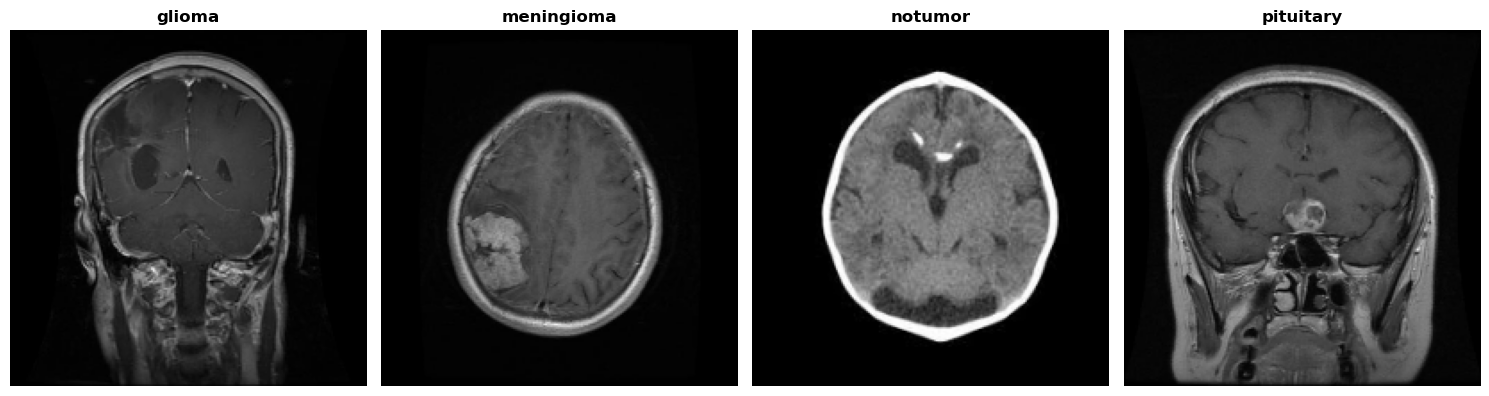

In [2]:
data_path = "./dataset/Training"
categories = ["glioma", "meningioma", "notumor", "pituitary"]

fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))

for ax, category in zip(axes, categories):
    category_path = os.path.join(data_path, category)
    images = os.listdir(category_path)
    if images:
        image_path = os.path.join(category_path, images[10])
        img = cv2.imread(image_path)
        img = cv2.resize(img, (200, 200))
        ax.imshow(img)
        ax.set_title(category, fontweight='bold')
        ax.axis('off')
    else:
        ax.set_title(f"No images in {category}")
        ax.axis('off')

plt.tight_layout()
plt.show()

### Visualizing and Cropping Extreme Points in MRI Images

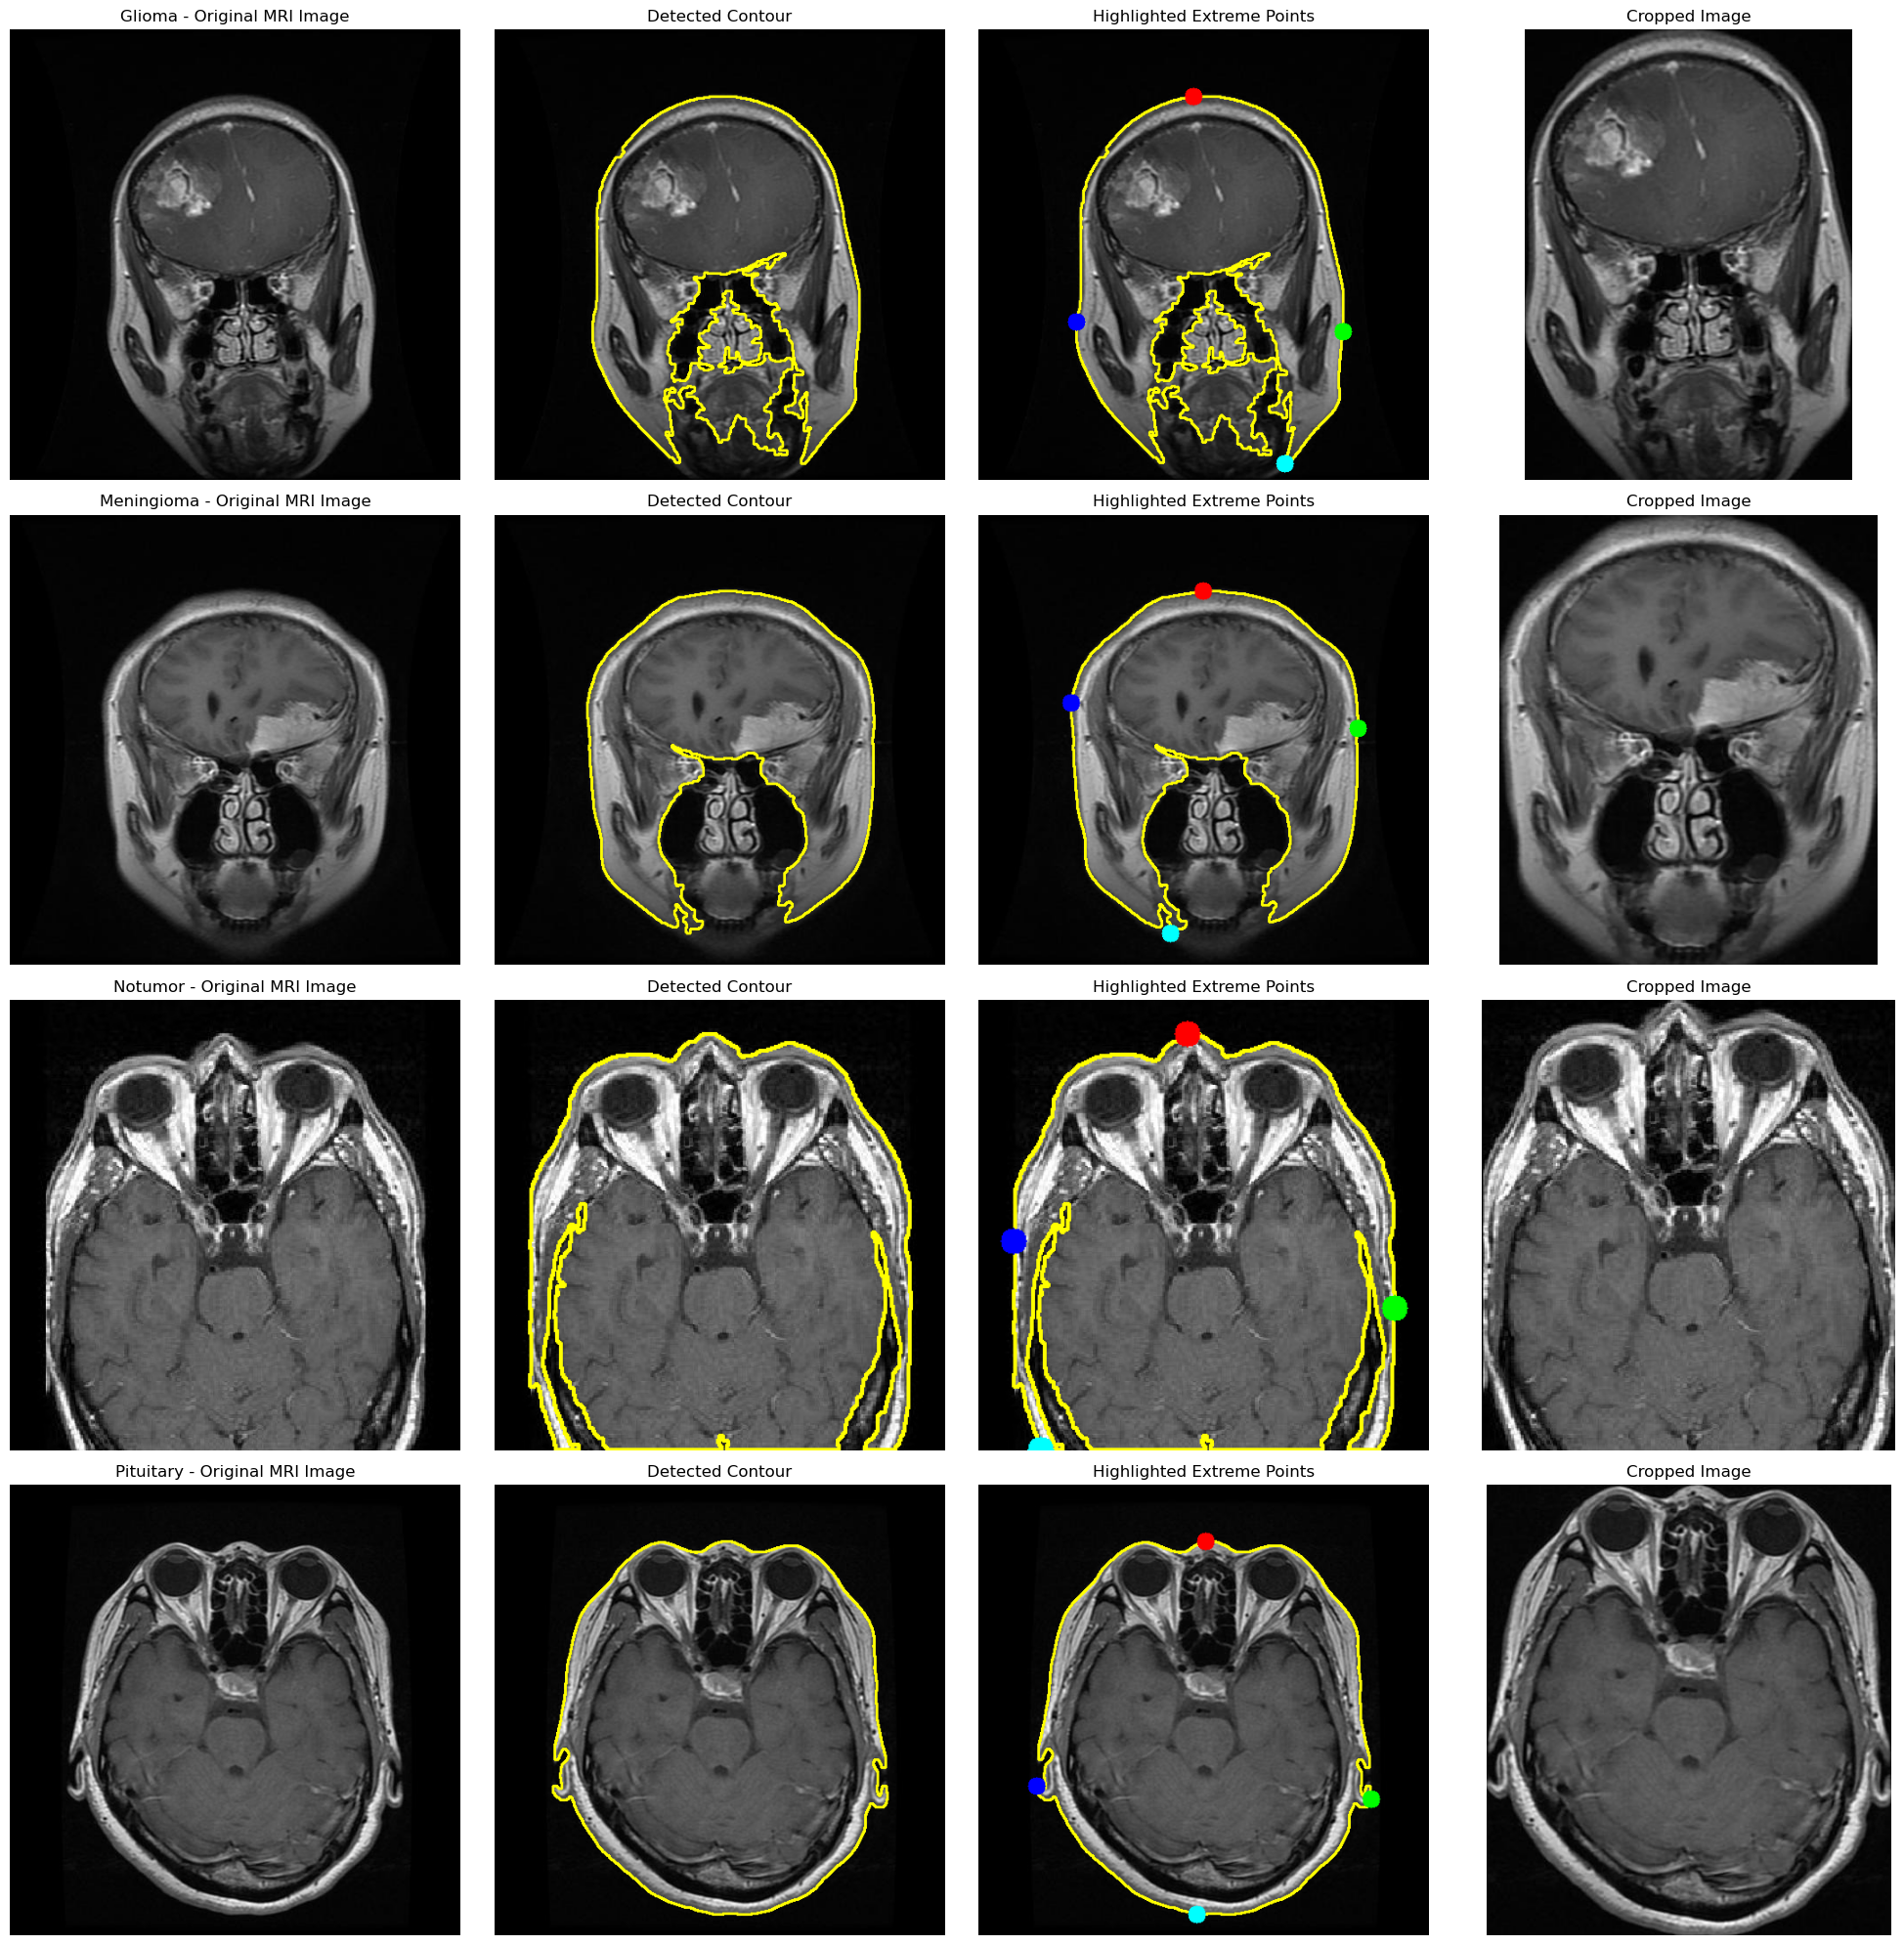

In [3]:
def crop_extreme_points(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return new_img, c, extLeft, extRight, extTop, extBot

fig, axes = plt.subplots(len(categories), 4, figsize=(20, 5 * len(categories)))

for i, category in enumerate(categories):
    category_path = os.path.join(data_path, category)
    images = os.listdir(category_path)
    first_image_path = os.path.join(category_path, images[0])
    
    img = cv2.imread(first_image_path)
    
    cropped_img, cnt, extLeft, extRight, extTop, extBot = crop_extreme_points(img)

    axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(f'{category.capitalize()} - Original MRI Image')
    axes[i, 0].axis('off')

    img_with_contour = img.copy()
    cv2.drawContours(img_with_contour, [cnt], -1, (0, 255, 255), 2)
    axes[i, 1].imshow(cv2.cvtColor(img_with_contour, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title('Detected Contour')
    axes[i, 1].axis('off')

    img_with_points = img_with_contour.copy()
    cv2.circle(img_with_points, extLeft, 10, (255, 0, 0), -1)
    cv2.circle(img_with_points, extRight, 10, (0, 255, 0), -1)
    cv2.circle(img_with_points, extTop, 10, (0, 0, 255), -1)
    cv2.circle(img_with_points, extBot, 10, (255, 255, 0), -1)
    axes[i, 2].imshow(cv2.cvtColor(img_with_points, cv2.COLOR_BGR2RGB))
    axes[i, 2].set_title('Highlighted Extreme Points')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    axes[i, 3].set_title('Cropped Image')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

### Creating Directory Structure for Cropped Training and Testing Data

In [4]:
def create_directory_structure(root):
    os.makedirs(os.path.join(root, 'Cropped', 'Training'), exist_ok=True)
    os.makedirs(os.path.join(root, 'Cropped', 'Testing'), exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(root, 'Cropped', 'Training', category), exist_ok=True)
        os.makedirs(os.path.join(root, 'Cropped', 'Testing', category), exist_ok=True)

### Processing and Saving Cropped Images with Error Handling

In [5]:
def process_and_save_images(data_path, target_path):
    for category in categories:
        category_path = os.path.join(data_path, category)
        target_category_path = os.path.join(target_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image {img_path}. Skipping...")
                continue
            try:
                cropped_img, cnt, extLeft, extRight, extTop, extBot = crop_extreme_points(img)
                if cropped_img is None or not isinstance(cropped_img, np.ndarray):
                    print(f"Invalid cropped image for {img_path}. Skipping...")
                    continue
                save_path = os.path.join(target_category_path, img_name)
                success = cv2.imwrite(save_path, cropped_img)
                if not success:
                    print(f"Error saving image {save_path}")
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

### Loading Images and Labels with Image Paths

In [6]:
def load_images_and_labels(data_path):
    images = []
    labels = []
    image_paths = []
    for category in categories:
        category_path = os.path.join(data_path, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image {img_path}. Skipping...")
                continue
            img = cv2.resize(img, (200, 200))
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            labels.append(categories.index(category))
            image_paths.append(img_path)
    return np.array(images), np.array(labels), image_paths

### Define Paths for Training and Testing Data

In [7]:
root = "dataset"
data_path_train = os.path.join(root, "Training")
data_path_test = os.path.join(root, "Testing")

print(data_path_train)
print(data_path_test)

dataset\Training
dataset\Testing


### Create Directory Structure for Cropped Images

In [8]:
create_directory_structure(root)

### Process and Save Cropped Images

In [9]:
process_and_save_images(data_path_train, os.path.join(root, 'Cropped', 'Training'))
process_and_save_images(data_path_test, os.path.join(root, 'Cropped', 'Testing'))

### Setting Paths for Cropped Training and Testing Data

In [8]:
cropped_path_train = os.path.join(root, "Cropped\Training")
cropped_path_test = os.path.join(root, "Cropped\Testing")

### Loading Cropped Training and Testing Data with Labels

In [9]:
X_train, Y_train, train_image_paths = load_images_and_labels(cropped_path_train)
X_test, Y_test, test_image_paths = load_images_and_labels(cropped_path_test)

### Displaying Shapes of Training and Testing Data Arrays

In [10]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (5712, 200, 200, 3)
Y_train shape: (5712,)
X_test shape: (1311, 200, 200, 3)
Y_test shape: (1311,)


### Counting Instances in Each Training Category

In [11]:
train_counter = Counter(Y_train)

for category_index, count in train_counter.items():
    category_name = categories[category_index]
    print(f"{category_name} (Train): {count}")

glioma (Train): 1321
meningioma (Train): 1339
notumor (Train): 1595
pituitary (Train): 1457


### Counting Instances in Each Testing Category

In [12]:
test_counter = Counter(Y_test)

for category_index, count in test_counter.items():
    category_name = categories[category_index]
    print(f"{category_name} (Test): {count}")

glioma (Test): 300
meningioma (Test): 306
notumor (Test): 405
pituitary (Test): 300


### One-Hot Encoding Labels for Training and Testing Data

In [13]:
Y_train = to_categorical(Y_train, num_classes=len(categories))
Y_test = to_categorical(Y_test, num_classes=len(categories))

print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

Y_train shape: (5712, 4)
Y_test shape: (1311, 4)


### Creating DataFrames for Training and Testing Data with Labels

In [14]:
df_train = pd.DataFrame(Y_train, columns=categories)
df_train['image_path'] = train_image_paths

df_test = pd.DataFrame(Y_test, columns=categories)
df_test['image_path'] = test_image_paths

display(df_train.head())
display(df_train.tail())
display(df_test.head())
display(df_test.tail())

glioma  meningioma  notumor  pituitary  \
0     1.0         0.0      0.0        0.0   
1     1.0         0.0      0.0        0.0   
2     1.0         0.0      0.0        0.0   
3     1.0         0.0      0.0        0.0   
4     1.0         0.0      0.0        0.0   

                                         image_path  
0  dataset\Cropped\Training\glioma\Tr-glTr_0000.jpg  
1  dataset\Cropped\Training\glioma\Tr-glTr_0001.jpg  
2  dataset\Cropped\Training\glioma\Tr-glTr_0002.jpg  
3  dataset\Cropped\Training\glioma\Tr-glTr_0003.jpg  
4  dataset\Cropped\Training\glioma\Tr-glTr_0004.jpg

glioma  meningioma  notumor  pituitary  \
5707     0.0         0.0      0.0        1.0   
5708     0.0         0.0      0.0        1.0   
5709     0.0         0.0      0.0        1.0   
5710     0.0         0.0      0.0        1.0   
5711     0.0         0.0      0.0        1.0   

                                             image_path  
5707  dataset\Cropped\Training\pituitary\Tr-pi_1452.jpg  
5708  dataset\Cropped\Training\pituitary\Tr-pi_1453.jpg  
5709  dataset\Cropped\Training\pituitary\Tr-pi_1454.jpg  
5710  dataset\Cropped\Training\pituitary\Tr-pi_1455.jpg  
5711  dataset\Cropped\Training\pituitary\Tr-pi_1456.jpg

glioma  meningioma  notumor  pituitary  \
0     1.0         0.0      0.0        0.0   
1     1.0         0.0      0.0        0.0   
2     1.0         0.0      0.0        0.0   
3     1.0         0.0      0.0        0.0   
4     1.0         0.0      0.0        0.0   

                                        image_path  
0  dataset\Cropped\Testing\glioma\Te-glTr_0000.jpg  
1  dataset\Cropped\Testing\glioma\Te-glTr_0001.jpg  
2  dataset\Cropped\Testing\glioma\Te-glTr_0002.jpg  
3  dataset\Cropped\Testing\glioma\Te-glTr_0003.jpg  
4  dataset\Cropped\Testing\glioma\Te-glTr_0004.jpg

glioma  meningioma  notumor  pituitary  \
1306     0.0         0.0      0.0        1.0   
1307     0.0         0.0      0.0        1.0   
1308     0.0         0.0      0.0        1.0   
1309     0.0         0.0      0.0        1.0   
1310     0.0         0.0      0.0        1.0   

                                            image_path  
1306  dataset\Cropped\Testing\pituitary\Te-pi_0295.jpg  
1307  dataset\Cropped\Testing\pituitary\Te-pi_0296.jpg  
1308  dataset\Cropped\Testing\pituitary\Te-pi_0297.jpg  
1309  dataset\Cropped\Testing\pituitary\Te-pi_0298.jpg  
1310  dataset\Cropped\Testing\pituitary\Te-pi_0299.jpg

### Normalization of Training and Testing Images

In [15]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

### Shuffling Training Data and Labels

In [16]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

### DataFrame with Shuffled Training Labels

In [17]:
df_train2 = pd.DataFrame(Y_train, columns=categories)
display(df_train2.head())

glioma  meningioma  notumor  pituitary
0     0.0         1.0      0.0        0.0
1     0.0         0.0      1.0        0.0
2     1.0         0.0      0.0        0.0
3     0.0         0.0      0.0        1.0
4     0.0         0.0      0.0        1.0

### Splitting Training Data into Training and Validation Sets

In [18]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

### Dimensions of Training and Validation Data after Splitting

In [19]:
print("X_train shape after split:", X_train.shape)
print("Y_train shape after split:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

X_train shape after split: (4569, 200, 200, 3)
Y_train shape after split: (4569, 4)
X_val shape: (1143, 200, 200, 3)
Y_val shape: (1143, 4)


### ImageDataGenerator Configuration for Data Augmentation

In [20]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

### Visualizing Original and Augmented Images Using ImageDataGenerator

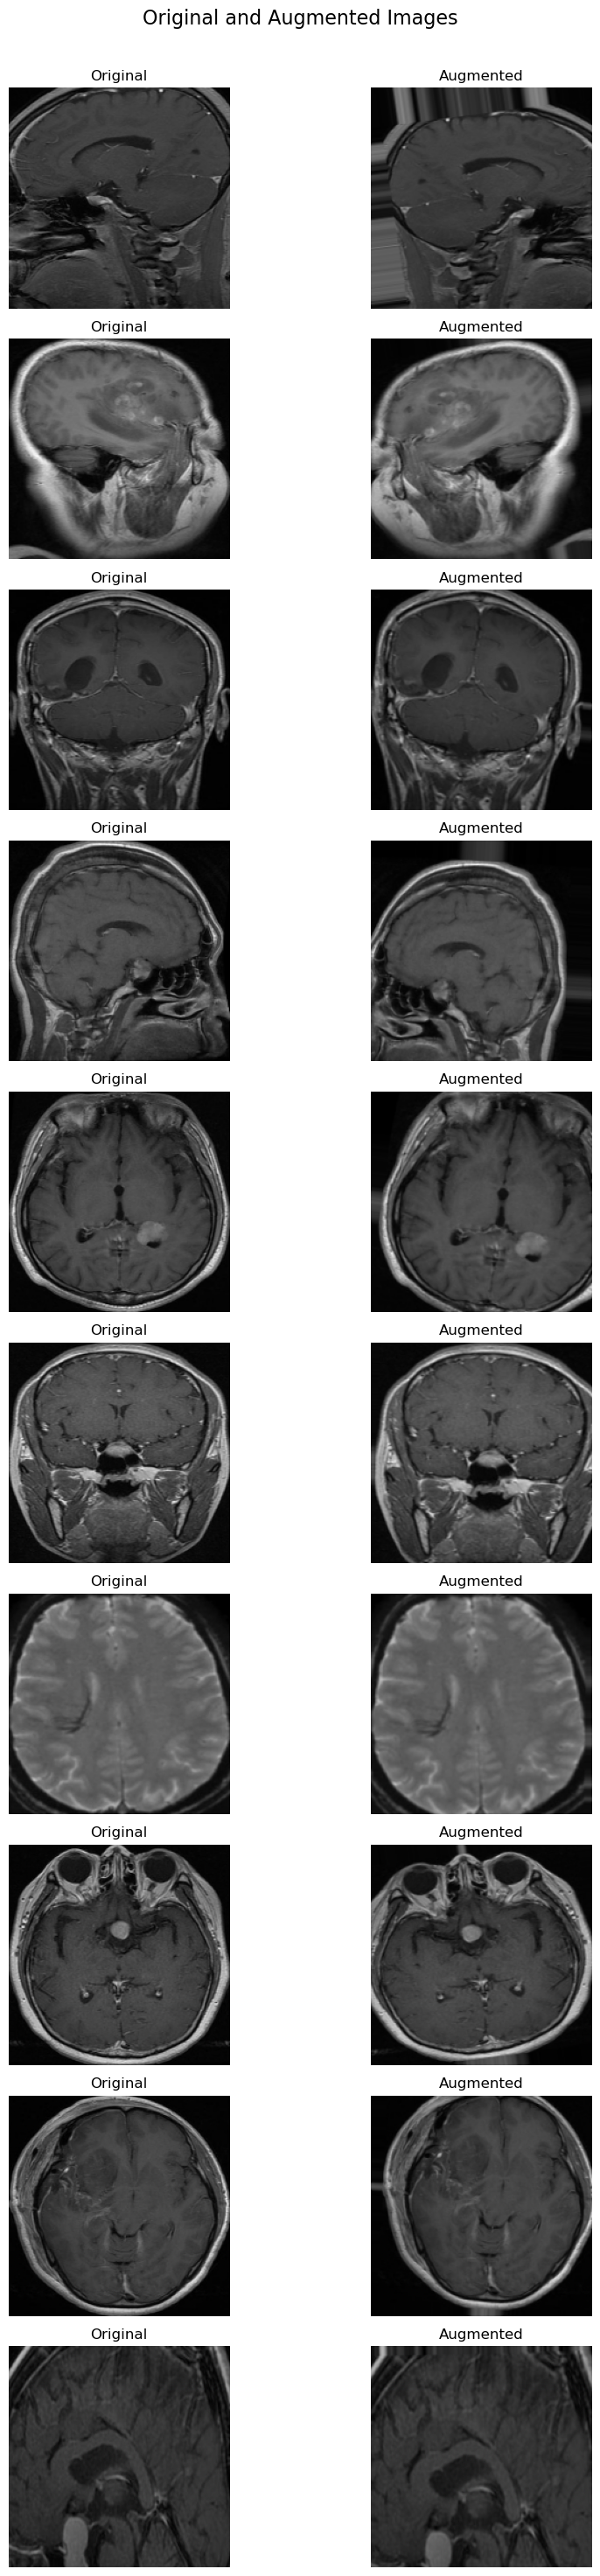

In [21]:
sample_images = X_train[:10]

fig, axes = plt.subplots(10, 2, figsize=(10, 15 * 2))

fig.suptitle("Original and Augmented Images", fontsize=16)

for i in range(10):
    axes[i, 0].imshow(sample_images[i])
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    augmented_image = datagen.random_transform(sample_images[i])
    axes[i, 1].imshow(augmented_image)
    axes[i, 1].set_title("Augmented")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

### Creating a Training Generator with ImageDataGenerator

In [22]:
train_generator = datagen.flow(X_train, Y_train, batch_size=64)

### Creating a Validation Generator with ImageDataGenerator

In [23]:
val_datagen = ImageDataGenerator()

In [24]:
val_generator = val_datagen.flow(X_val, Y_val, batch_size=64)

### Convolutional Neural Network Architecture Summary

In [25]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(256, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(len(categories), activation='softmax'))

cnn_model.summary()

C:\Users\TVA\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,628,484 (51.99 MB)

 Trainable params: 13,628,484 (51.99 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Convolutional Neural Network Model

In [26]:
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

### Visualization of Convolutional Neural Network Model Architecture

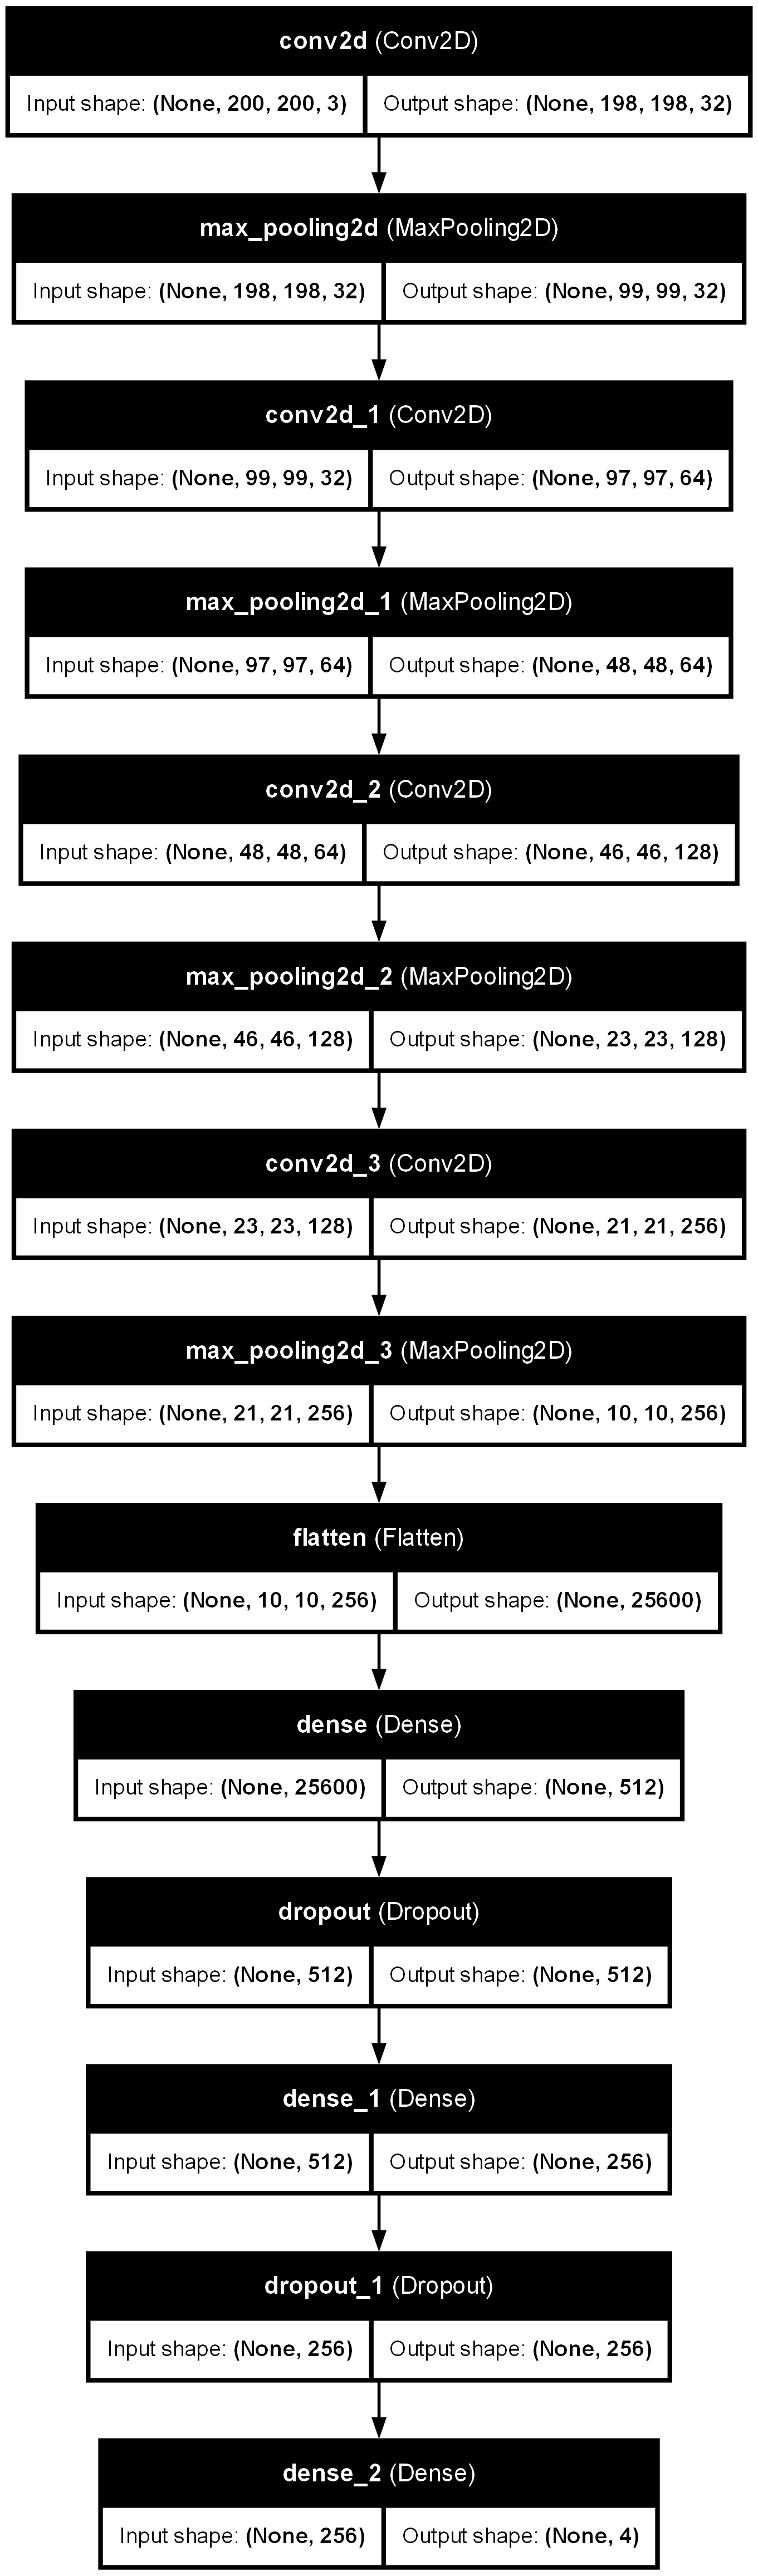

In [27]:
plot_model(cnn_model, to_file='cnn_model_plot.png', show_shapes=True, show_layer_names=True)

### Setting Callbacks for Early Stopping and Model Checkpointing

In [89]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_best_weights.keras', save_best_only=True, monitor='val_loss')

callbacks = [early_stopping, model_checkpoint]

### Training Convolutional Neural Network

In [29]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=callbacks,
    epochs=50
)

Epoch 1/50


C:\Users\TVA\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.3320 - loss: 1.3253 - val_accuracy: 0.6754 - val_loss: 0.8233
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6232 - loss: 0.8941 - val_accuracy: 0.7165 - val_loss: 0.7057
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7068 - loss: 0.7360 - val_accuracy: 0.7673 - val_loss: 0.5756
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.7698 - loss: 0.6036 - val_accuracy: 0.7743 - val_loss: 0.5833
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7943 - loss: 0.5438 - val_accuracy: 0.7997 - val_loss: 0.5413
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8158 - loss: 0.4759 - val_accuracy: 0.8478 - val_loss: 0.4031
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8480 - loss: 0.4324 - val_accuracy: 0.8425 - val_loss: 0.4248
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.8563 - loss: 0.3784 - val_accuracy: 0.8241 - val_loss: 0.480

### Saving the Trained Convolutional Neural Network Model

In [30]:
cnn_model.save("cnn_model.h5")

### Plotting Learning Curves

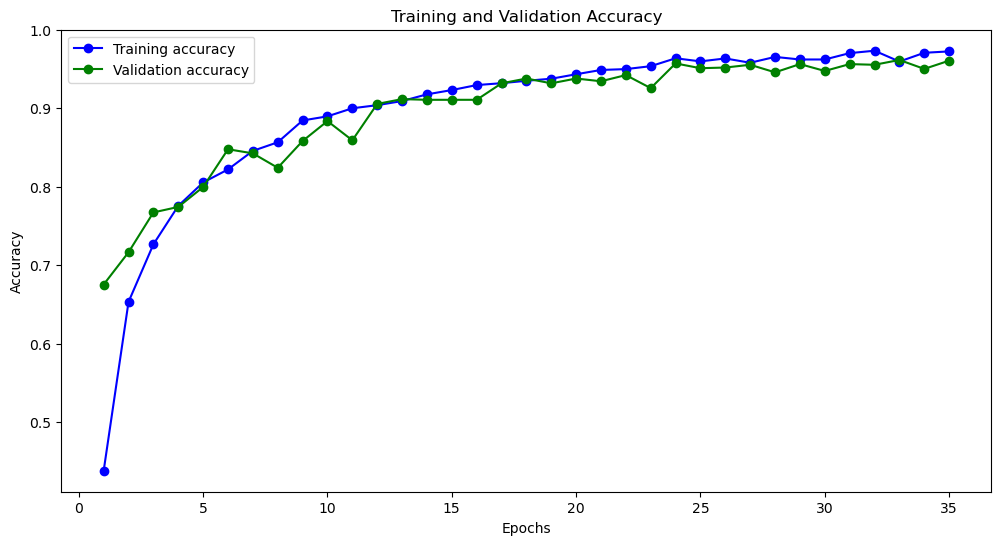

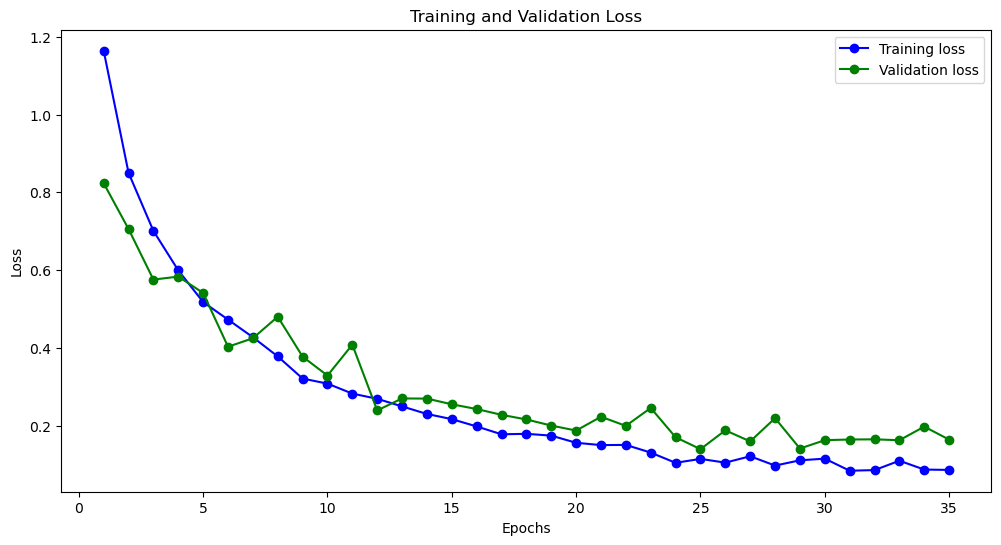

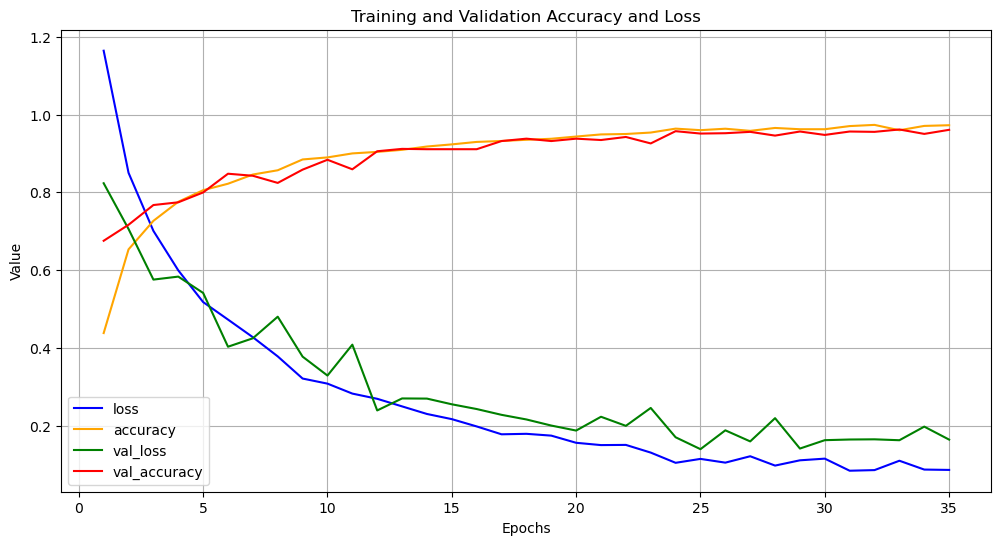

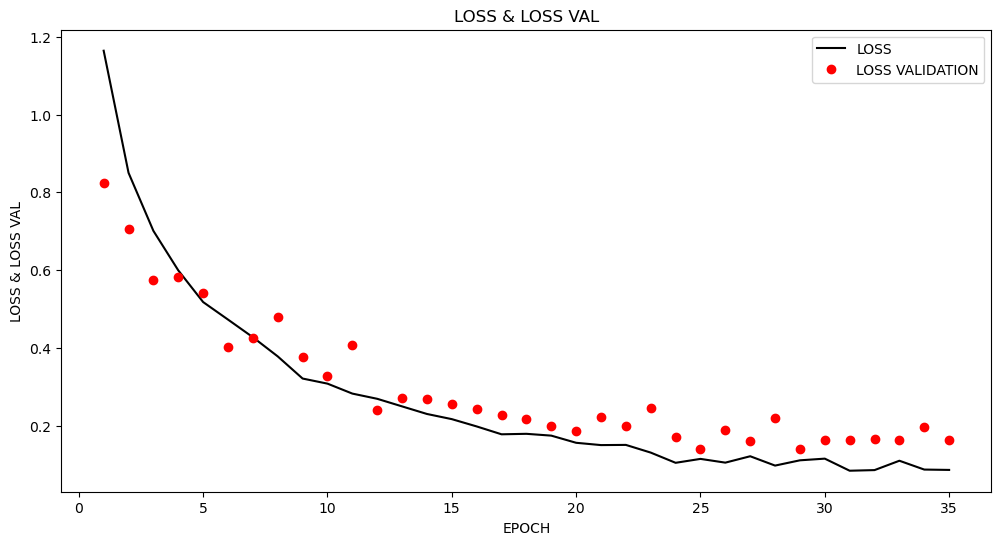

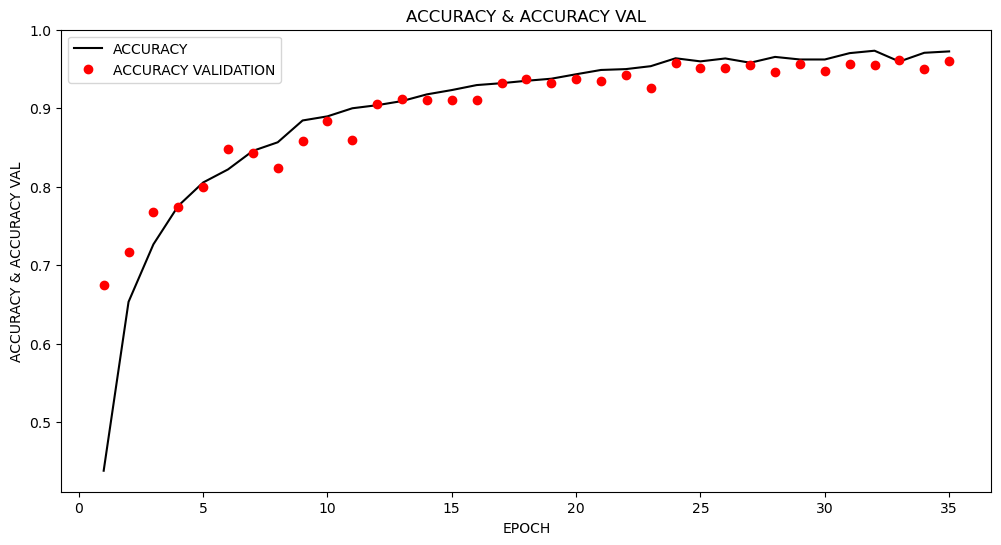

In [38]:
acc = cnn_history.history['accuracy']
val_acc = cnn_history.history['val_accuracy']
loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'go-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'b-', label='loss')
plt.plot(epochs, acc, 'orange', label='accuracy')
plt.plot(epochs, val_loss, 'g-', label='val_loss')
plt.plot(epochs, val_acc, 'r-', label='val_accuracy')
plt.title('Training and Validation Accuracy and Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs,loss,"k-",label="LOSS")
plt.plot(epochs,val_loss,"ro",label="LOSS VALIDATION")
plt.title("LOSS & LOSS VAL")
plt.xlabel("EPOCH")
plt.ylabel("LOSS & LOSS VAL")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs,acc,"k-",label="ACCURACY")
plt.plot(epochs,val_acc,"ro",label="ACCURACY VALIDATION")
plt.title("ACCURACY & ACCURACY VAL")
plt.xlabel("EPOCH")
plt.ylabel("ACCURACY & ACCURACY VAL")
plt.legend()
plt.show()

### Loading the model

In [14]:
cnn_model = load_model("cnn_model.h5")

### Test Accuracy Evaluation

In [15]:
Y_pred = cnn_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

test_accuracy = accuracy_score(Y_true, Y_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print("---------------------------------------------------------------------------")
print(Counter(Y_true))
print(Counter(Y_pred_classes))
print(f'Original Class: {Y_true[:10]} & Predicted Class: {Y_pred_classes[:10]}')
print(f'Original Class: {Y_true[-10:]} & Predicted Class: {Y_pred_classes[-10:]}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step
Test Accuracy: 96.11%
---------------------------------------------------------------------------
Counter({2: 405, 1: 306, 0: 300, 3: 300})
Counter({2: 414, 1: 307, 3: 304, 0: 286})
Original Class: [0 0 0 0 0 0 0 0 0 0] & Predicted Class: [0 0 0 0 0 0 0 0 0 0]
Original Class: [3 3 3 3 3 3 3 3 3 3] & Predicted Class: [3 3 3 3 3 3 3 3 3 3]


### Plotting confusion matrix

[[278  14   3   5]
 [  4 287  13   2]
 [  4   3 398   0]
 [  0   3   0 297]]


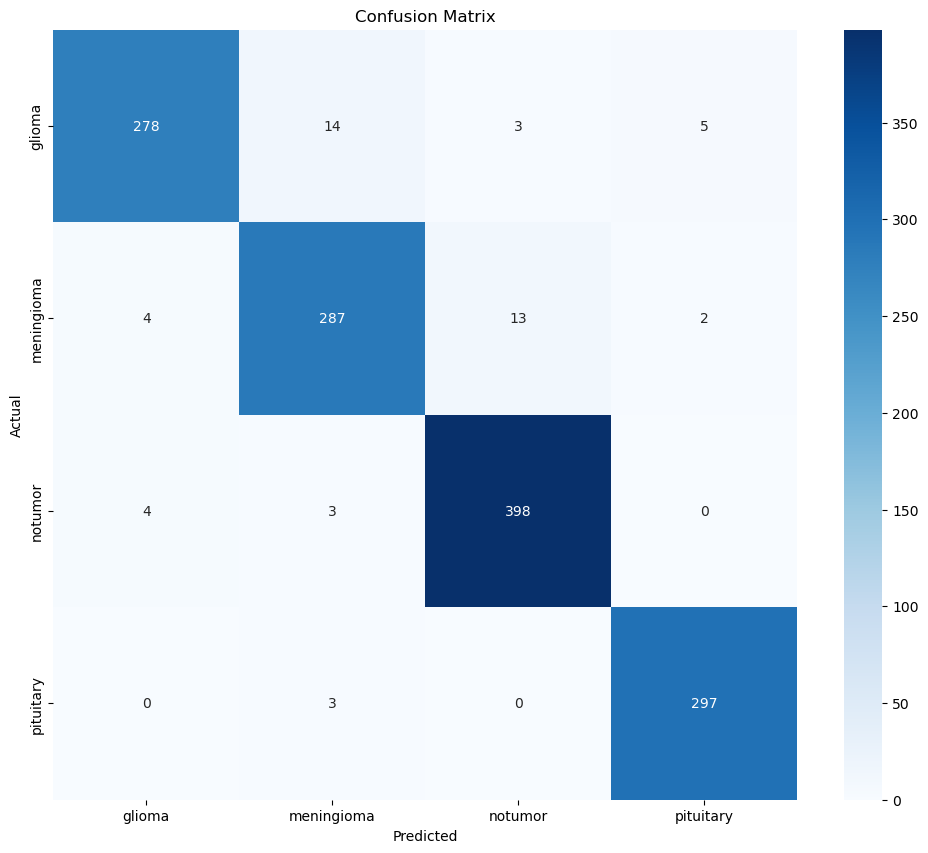


---------------------------------------------------------------------------
              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.93      0.94      0.94       306
     notumor       0.96      0.98      0.97       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [16]:
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

print(conf_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\n---------------------------------------------------------------------------")
print(classification_report(Y_true, Y_pred_classes, target_names=categories))

### Random Sample Predictions on Test Images

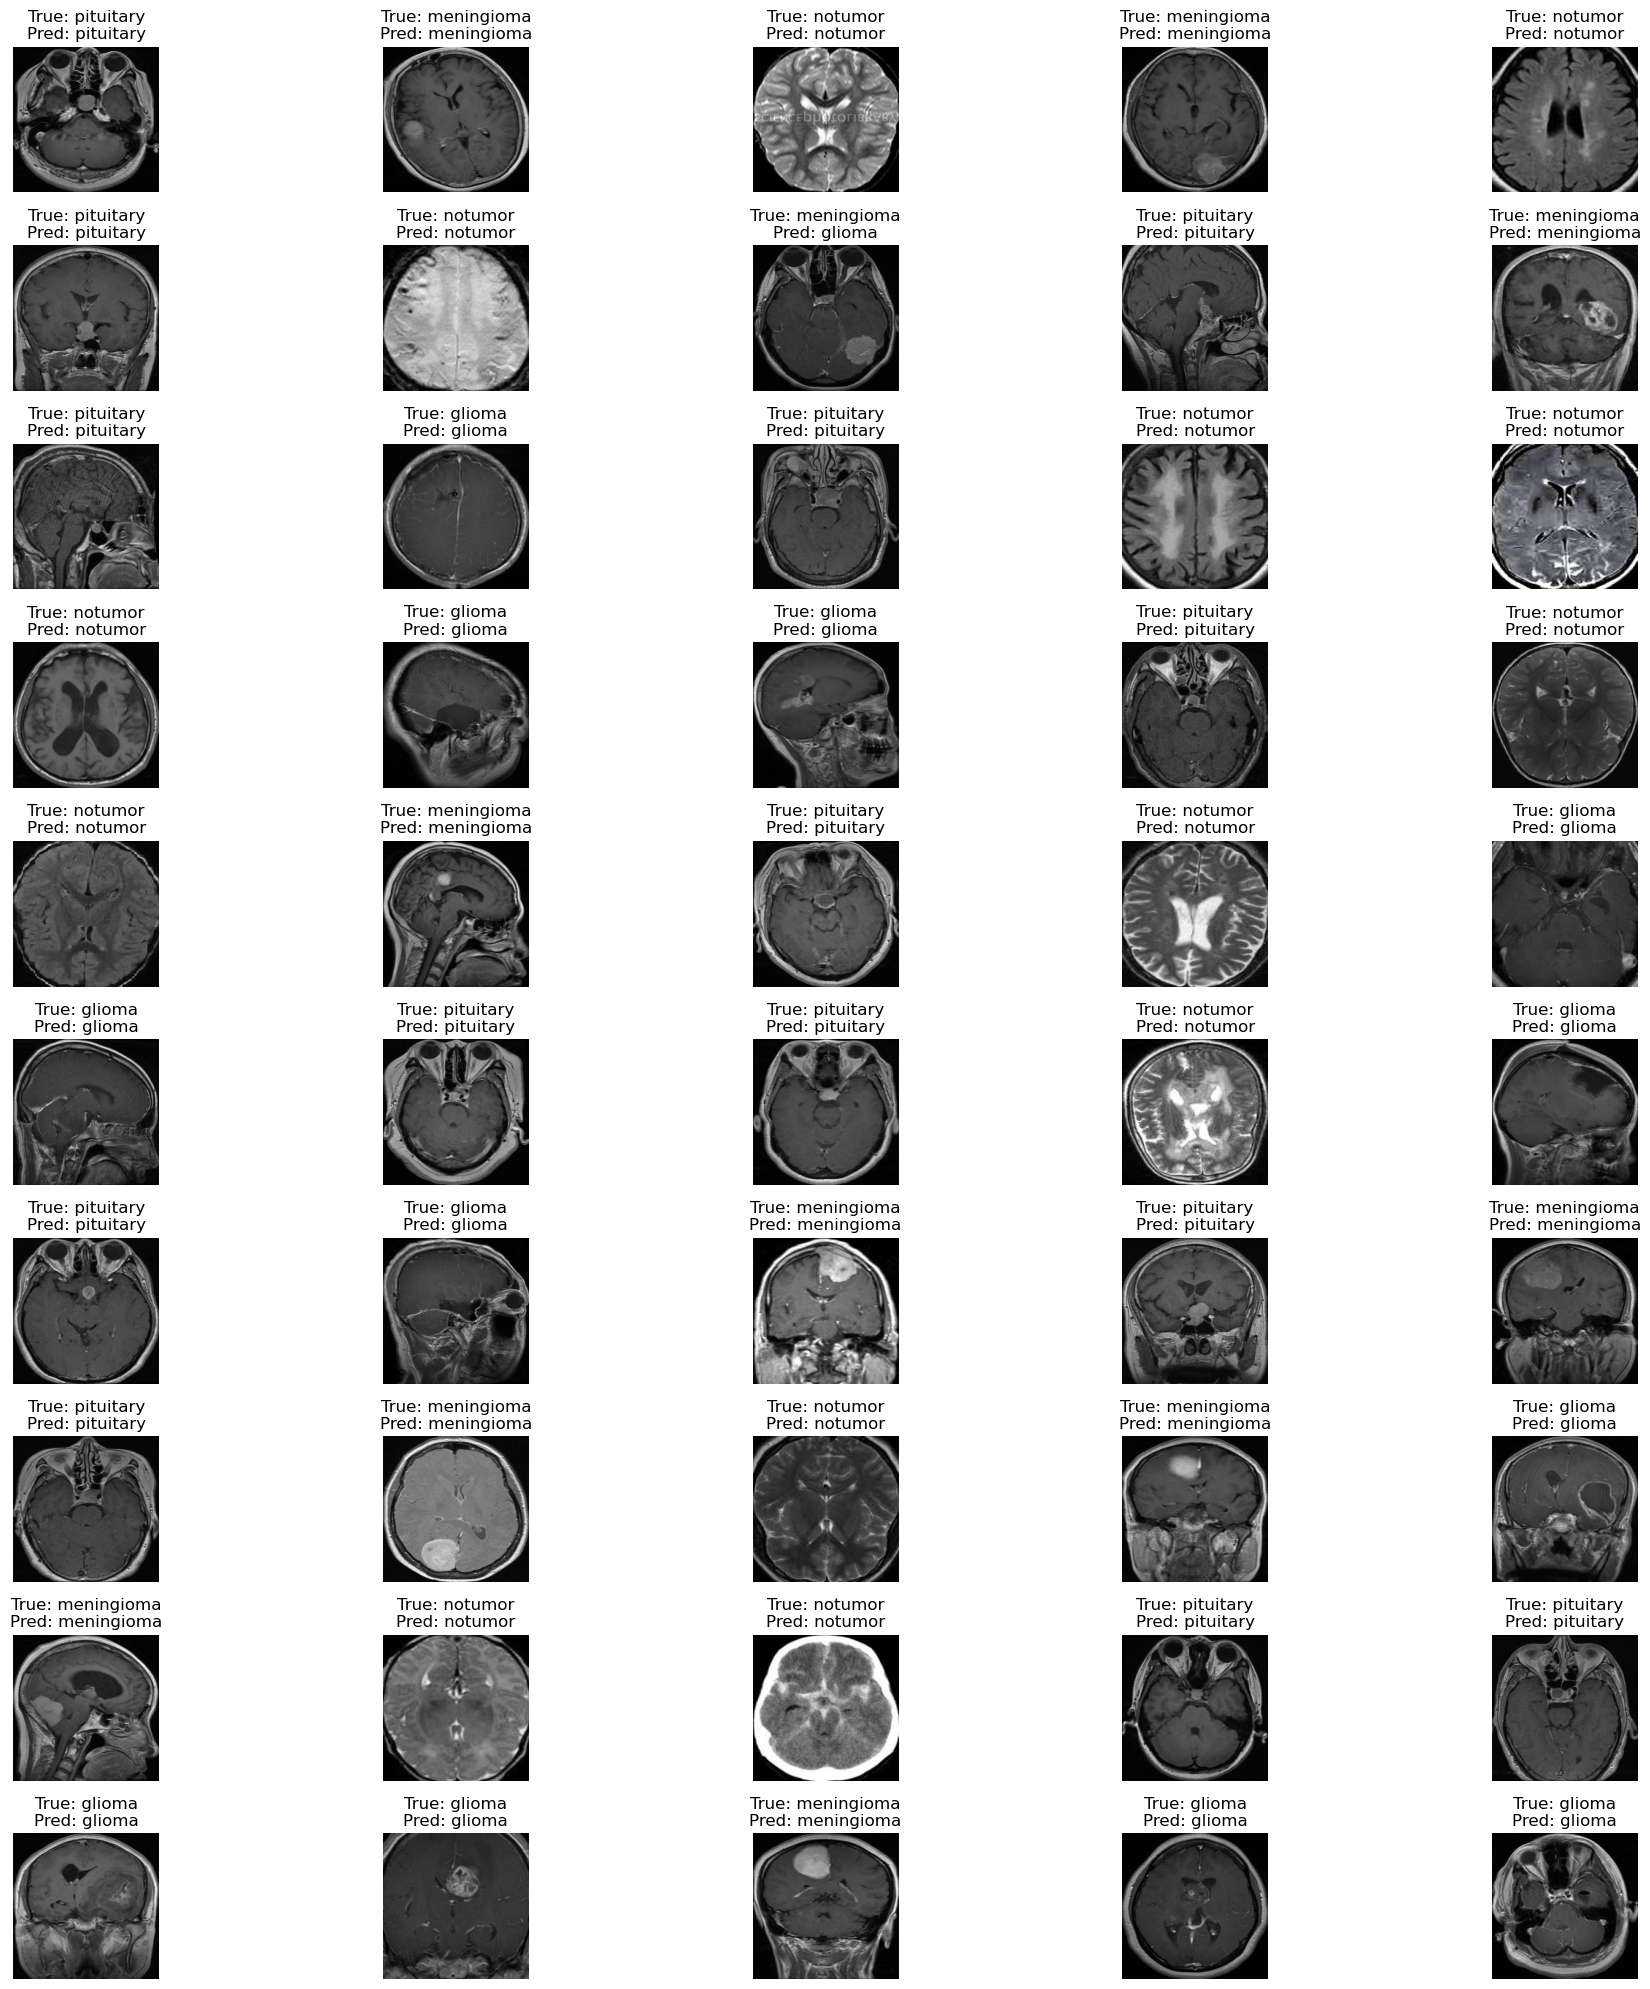

In [20]:
plt.figure(figsize=(20, 20))

for i in range(50):
    random_num = random.randrange(1, 1311)
    plt.subplot(10, 5, i + 1)
    plt.imshow(X_test[random_num])
    plt.title(f"True: {categories[Y_true[random_num]]}\nPred: {categories[Y_pred_classes[random_num]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()